<a href="https://colab.research.google.com/github/mattn12/ENPH353_Team5/blob/master/Competition%20License%20Plate%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENPH 353 Lab 5 - Character Recogition


## Import Packages

In [6]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
import math
import re

from PIL import Image, ImageFont, ImageDraw
from collections import Counter
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

from ipywidgets import interact
import ipywidgets as ipywidgets

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


## License Plate Generator

In [12]:
# Run this command only once:

# makes the output folder /content/pictures/
# !mkdir pictures

In [13]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
# !gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 63.6MB/s]


In [14]:
path = "/content/"

NUMBER_OF_PLATES = 500

for i in range(0, NUMBER_OF_PLATES):
  # Pick two random letters
  plate_alpha = ""
  for _ in range(0, 2):
      plate_alpha += (random.choice(string.ascii_uppercase))

  # Pick two random numbers
  num = randint(0, 99)
  plate_num = "{:02d}".format(num)
    
  # Write plate to image
  blank_plate = cv2.imread(path+'blank_plate.png')

  # Convert into a PIL image (this is so we can use the monospaced fonts)
  blank_plate_pil = Image.fromarray(blank_plate)

  # Get a drawing context
  draw = ImageDraw.Draw(blank_plate_pil)
  monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                  size=165)
  draw.text(xy=(48, 75),
            text=plate_alpha + " " + plate_num ,
            fill=(255,0,0), font=monospace)

  # Convert back to OpenCV image and save
  blank_plate = np.array(blank_plate_pil)

  # Write license plate to file
  cv2.imwrite(os.path.join(path + "pictures/", 
                            "plate_{}{}.png".format(plate_alpha,plate_num)),
                            blank_plate)

## Authorize Google Drive Access

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Retrieve File Names of Plates


In [16]:
folder = "/content/pictures"
labels_raw = !ls "{folder}"
labels = labels_raw[0].split()
#print(labels_raw)

In [26]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

['plate_AB29.png', 'plate_AB45.png', 'plate_AC57.png', 'plate_AC63.png', 'plate_AH37.png', 'plate_AH69.png', 'plate_AH98.png', 'plate_AK12.png', 'plate_AL23.png', 'plate_AN48.png', 'plate_AU28.png', 'plate_AV20.png', 'plate_AY41.png', 'plate_AY66.png', 'plate_BD02.png', 'plate_BD39.png', 'plate_BD85.png', 'plate_BD90.png', 'plate_BF13.png', 'plate_BG72.png', 'plate_BH70.png', 'plate_BH96.png', 'plate_BI77.png', 'plate_BJ56.png', 'plate_BM80.png', 'plate_BN59.png', 'plate_BO99.png', 'plate_BQ67.png', 'plate_BQ86.png', 'plate_BR42.png', 'plate_BR62.png', 'plate_BS64.png', 'plate_BT72.png', 'plate_BT97.png', 'plate_BV10.png', 'plate_BY41.png', 'plate_BZ70.png', 'plate_BZ86.png', 'plate_CE54.png', 'plate_CE99.png', 'plate_CH05.png', 'plate_CH57.png', 'plate_CI00.png', 'plate_CL16.png', 'plate_CL19.png', 'plate_CM23.png', 'plate_CQ56.png', 'plate_CQ69.png', 'plate_CR25.png', 'plate_CR71.png', 'plate_CU87.png', 'plate_CY48.png', 'plate_CY54.png', 'plate_CZ36.png', 'plate_DD16.png', 'plate_DD

In [27]:
files = files_in_folder(folder)

print(files)

['plate_AB29.png', 'plate_AB45.png', 'plate_AC57.png', 'plate_AC63.png', 'plate_AH37.png', 'plate_AH69.png', 'plate_AH98.png', 'plate_AK12.png', 'plate_AL23.png', 'plate_AN48.png', 'plate_AU28.png', 'plate_AV20.png', 'plate_AY41.png', 'plate_AY66.png', 'plate_BD02.png', 'plate_BD39.png', 'plate_BD85.png', 'plate_BD90.png', 'plate_BF13.png', 'plate_BG72.png', 'plate_BH70.png', 'plate_BH96.png', 'plate_BI77.png', 'plate_BJ56.png', 'plate_BM80.png', 'plate_BN59.png', 'plate_BO99.png', 'plate_BQ67.png', 'plate_BQ86.png', 'plate_BR42.png', 'plate_BR62.png', 'plate_BS64.png', 'plate_BT72.png', 'plate_BT97.png', 'plate_BV10.png', 'plate_BY41.png', 'plate_BZ70.png', 'plate_BZ86.png', 'plate_CE54.png', 'plate_CE99.png', 'plate_CH05.png', 'plate_CH57.png', 'plate_CI00.png', 'plate_CL16.png', 'plate_CL19.png', 'plate_CM23.png', 'plate_CQ56.png', 'plate_CQ69.png', 'plate_CR25.png', 'plate_CR71.png', 'plate_CU87.png', 'plate_CY48.png', 'plate_CY54.png', 'plate_CZ36.png', 'plate_DD16.png', 'plate_DD

## Add noise to images

In [28]:
!mkdir noisy

mkdir: cannot create directory ‘noisy’: File exists


In [36]:
write_path = "/content/"

mean = 0
sigma = 10
height, width, channels = cv2.imread(write_path+'blank_plate.png').shape
gaussian_noise = np.random.normal(mean, sigma, (height, width, channels))

for plate in files:
  #read and crop plate
  pic_path = f"{folder}/{plate}"
  img = cv2.imread(pic_path, cv2.IMREAD_COLOR)
  blur = cv2.GaussianBlur(img, (5,5), 0)

  # add noise
  noise = blur + gaussian_noise

  # random range
  rr = 10
  randint(-rr,rr)

  srcPts = [[0, 0], [width, 0], [0, height], [width, height]]
  # List the output points in the same order as input
  dstPts = [[randint(-rr,rr), randint(-rr,rr)], 
            [width+randint(-rr,rr), randint(-rr,rr)], 
            [randint(-rr,rr), height+randint(-rr,rr)], 
            [width+randint(-rr,rr), height+randint(-rr,rr)]]
  # Get the transform
  m = cv2.getPerspectiveTransform(np.float32(srcPts), np.float32(dstPts))
  # Transform the image
  warp = cv2.warpPerspective(noise, m, (int(width), int(height)))

  # cv2_imshow(img)
  # cv2_imshow(blur)
  # cv2_imshow(gaussian_noise)
  # cv2_imshow(noise)
  # cv2_imshow(warp)

  # # Write license plate to file
  cv2.imwrite(os.path.join(write_path + "noisy/"+pic_path[18:]),warp)

In [37]:
noisy_folder = "/content/noisy"
noisy_files = files_in_folder(noisy_folder)

## Slice Images

In [38]:
#cropping settings
top = 100
bottom = 220
left = 47

In [43]:
value = 0
dataset = []

for plate in files:
  #read and crop plate
  path = f"{noisy_folder}/{plate}"
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = img[top:bottom,left:]
  
  allchars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

  # slice every letter
  # path string: /content/noisy/plate_AB29.png
  # start at index 
  letter1 = [img[:,0:100], allchars.find(path[21])]

  letter2 = [img[:,100:200], allchars.find(path[22])]
               
  letter3 = [img[:,300:400], allchars.find(path[23])]

  letter4 = [img[:,400:500], allchars.find(path[24])]

  dataset.append(letter1)
  dataset.append(letter2)
  dataset.append(letter3)
  dataset.append(letter4)


In [34]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [45]:
# for y in range(20):
#   cv2_imshow(dataset[y][0])
#   print(allchars[dataset[y][1]])

## Create Datasets for Neural Net

In [46]:
# Shuffle the dataset
np.random.shuffle(dataset)

# Genereate X and Y datasets
X_dataset_orig = np.array([data[0] for data in dataset])
Y_dataset_orig = np.array([[data[1]] for data in dataset]).T

NUMBER_OF_LABELS = 36
CONFIDENCE_THRESHOLD = 0.01

# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T



In [47]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 1980
Training examples: 1584
Test examples: 396
X shape: (1980, 120, 100, 3)
Y shape: (1980, 36)


## Building Neural Net

In [48]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [49]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(120, 100, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

In [51]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 98, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41216)             0         
                                                                 
 dropout (Dropout)           (None, 41216)             0

In [52]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Reset Weights

In [53]:
reset_weights(conv_model)

## Train Neural Net

In [54]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=16)

Epoch 1/20
99/99 [==============================] - 11s 23ms/step - loss: 2.0162 - acc: 0.4899 - val_loss: 0.7267 - val_acc: 0.7702
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.3796 - acc: 0.9034 - val_loss: 0.3525 - val_acc: 0.9015
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.2203 - acc: 0.9457 - val_loss: 0.1810 - val_acc: 0.9470
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.1494 - acc: 0.9621 - val_loss: 0.1167 - val_acc: 0.9646
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.0993 - acc: 0.9722 - val_loss: 0.2010 - val_acc: 0.9621
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.0913 - acc: 0.9792 - val_loss: 0.1311 - val_acc: 0.9697
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.0846 - acc: 0.9785 - val_loss: 0.0894 - val_acc: 0.9773
Epoch 8/20
99/99 [==============================] - 2s 18ms/step - loss: 0.0639 - 

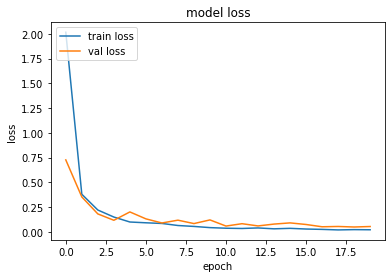

In [55]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

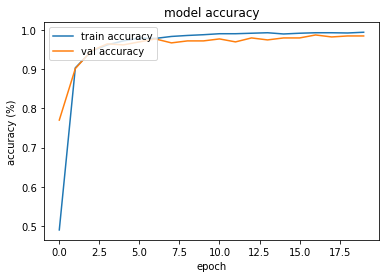

In [56]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

## Predicting Letters

In [57]:
# Display images in the training data set. 
def displayImage(index):
  img = X_dataset[index]
  # xpands image by one dimension
  img_aug = np.expand_dims(img, axis=0)
  # *not sure why we need to expand the img to predict
  y_predict = conv_model.predict(img_aug)
  
  # display the image to predict
  plt.imshow(img)  
  
  # print and compare input and predicted character along with confidence
  caption = ("Input: " + str(allchars[np.argmax(Y_dataset[index])])
                            + "\nPredicted: " + str(allchars[np.argmax(y_predict)])
                            + "\nConfidence: " + str(np.amax(y_predict)) + "\n") 
  
  # text settings in plot
  plt.text(0.5,0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')

# slider for choosing character to recognize
interact(displayImage, 
        index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
                                   step=1, value=10))


interactive(children=(IntSlider(value=10, description='index', max=1980), Output()), _dom_classes=('widget-int…

<function __main__.displayImage(index)>

## Confusion Matrix

In [58]:
#get set of all predictions using X_dataset
predictions = conv_model.predict(X_dataset)

62/62 [==============================] - 1s 7ms/step


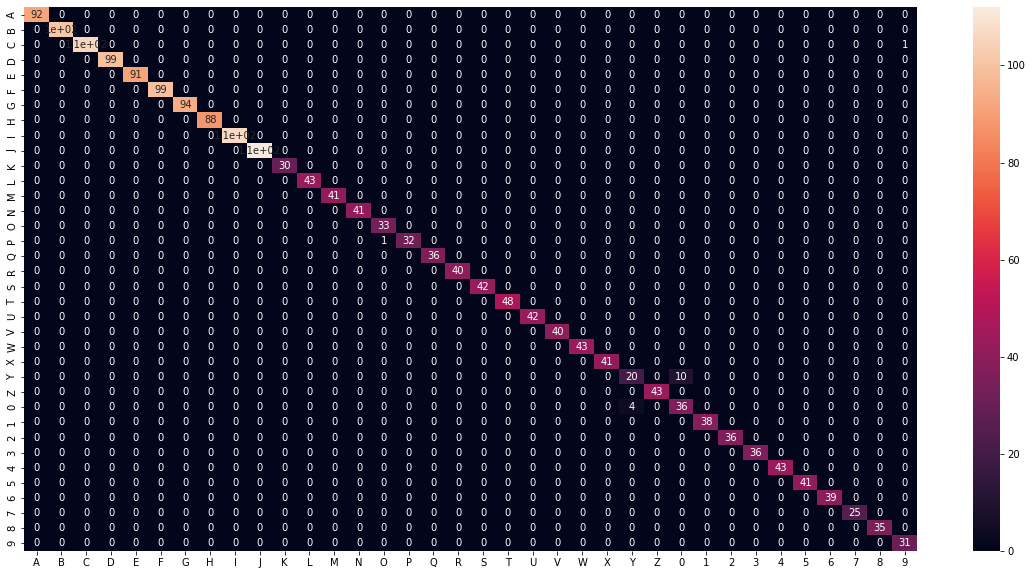

In [59]:
y_true = []
y_pred = []

# creates arrays of true chars and the predicted chars
for i in range(len(Y_dataset)):
  y_true.append(allchars[np.argmax(Y_dataset[i])])
  y_pred.append(allchars[np.argmax(predictions[i])])

# make the confusion matrix (i (rows): true, j (cols): predict)
cm = confusion_matrix(y_true, y_pred)
# dataframe for confusion matrix, (ie "axis ticks")
df_cm = pd.DataFrame(cm, index = [i for i in allchars],
                  columns = [i for i in allchars])
plt.figure(figsize = (20,10))
# plot heatmap of confusion matrix
sn.heatmap(df_cm, annot=True)

## Save the model